# MD Simultaion 

In [1]:
import copy
from pathlib import Path
import sys

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [2]:
import warnings

# 경고를 무시하도록 설정합니다.
#warnings.filterwarnings("ignore", message="PDB file is missing resid information.")
#warnings.filterwarnings("ignore", message="Reload offsets from trajectory")
#warnings.filterwarnings("ignore", message="duplicate atom")

warnings.filterwarnings("ignore")

In [3]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [4]:
prepare_protein = prepare_protein("./protein_rank_1_complex.pdb", ignore_missing_residues=False)

In [5]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file), proximityBonding=True, sanitize=False)
    print(rdkit_mol)
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

In [6]:
pdb_path = "./protein_rank_1_complex.pdb"
ligand_name = "UNL"
smiles = "COc1ccccc1N1CCN(C(=O)Nc2ccccc2C)CC1"

[14:21:29] WARNING: More than one matching pattern found - picking one



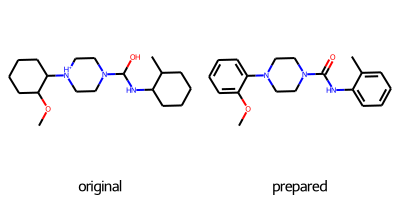

In [7]:
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

In [8]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)
    #print(off_mol)

    # add name for molecule
    off_mol.name = name
    #print(off_mol.name)

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])
    #print(element_counter_dict)

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    #print(mol_topology)
    mol_positions = off_mol.conformers[0]
    #print(mol_positions)

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")
    #print(mol_positions)

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [9]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

In [10]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    #print(md_protein_topology)
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    #print(md_ligand_topology)
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    #print(md_complex_topology)
    complex_topology = md_complex_topology.to_openmm()
    #print(complex_topology)

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [11]:
complex_topology, complex_positions = merge_protein_and_ligand(prepare_protein, omm_ligand)

In [12]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 4208 atoms.


In [13]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [14]:
forcefield = generate_forcefield(rdkit_ligand)

In [15]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.5 * unit.nanometers, ionicStrength=0.15 * unit.molar)

/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [16]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff)
integrator = mm.LangevinIntegrator(
    309.65 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [17]:
simulation.minimizeEnergy()
with open("topology_ns1_1.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

In [18]:
# output settings
# during 1 ps simulation

steps = 50000  # corresponds to 100 fs
write_interval = 500  # write every 10 fs
log_interval = 250  # log progress to stdout every 5 fs
simulation.reporters.append(
    md.reporters.XTCReporter(file=str("trajectory_1.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [18]:
# output settings
# during 1 ns simulation

steps = 50000000  # corresponds to 100 fs
write_interval = 500  # write every 10 fs
log_interval = 500  # log progress to stdout every 5 fs
simulation.reporters.append(
    md.reporters.XTCReporter(file=str("trajectory_ns1_1.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [19]:
simulation.context.setVelocitiesToTemperature(309.65 * unit.kelvin)
simulation.step(steps)  # perform the simulation

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
0.0%	500	-1009409.3125	246.89350764504368	0	--
0.0%	1000	-982969.8125	282.29330144499306	10.6	9:10:20:20
0.0%	1500	-971614.125	299.82176305912793	10.6	9:11:24:06
0.0%	2000	-965182.125	303.28377661996643	10.5	9:12:27:29
0.0%	2500	-959880.75	305.6838244356911	10.4	9:13:47:15
0.0%	3000	-959739.875	306.3593842090942	10.3	9:17:11:51
0.0%	3500	-959543.0	309.15025669859835	10.2	9:19:53:45
0.0%	4000	-960157.125	310.1409802313585	10.1	9:21:31:21
0.0%	4500	-960151.875	310.97885351412924	10	9:23:01:13
0.0%	5000	-959911.125	310.0137658063007	9.99	10:0:05:53
0.0%	5500	-959207.25	310.23511189153646	9.96	10:1:02:06
0.0%	6000	-957258.625	310.11519382519003	9.93	10:1:42:35
0.0%	6500	-957393.5625	310.5767264776356	9.91	10:2:10:37
0.0%	7000	-956937.8125	311.17117794383046	9.88	10:2:47:28
0.0%	7500	-956658.5	311.589345075416	9.87	10:3:10:08
0.0%	8000	-956652.625	310.9873187226771	9.86	10:3:27:39
0.0%	85

KeyboardInterrupt: 

In [20]:
# Check the trajectory exists and is not empty
import os 
result = "./trajectory_ns1_1.xtc"
file_info = os.stat(result)
print(file_info)
#result.stat().st_size > 0
# NBVAL_CHECK_OUTPUT

os.stat_result(st_mode=33204, st_ino=235276793, st_dev=2080, st_nlink=1, st_uid=1002, st_gid=1002, st_size=22878668, st_atime=1717124168, st_mtime=1717131498, st_ctime=1717131498)


# Analysis MD Simulation results

## RMSD Analysis

In [19]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA


In [20]:
md_universe = mda.Universe(str("./topology_1.pdb"), str("./trajectory_1.xtc"))

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:276: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [21]:
# Set trajectory pointer to first frame as reference
md_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=md_universe, reference=md_universe, select="protein", in_memory=True
)
alignment.run()

In [22]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()

    columns = [selection1, *selection2] if selection2 else [selection1]
    #print(rmsd_analysis.results)
    #print(rmsd_analysis)
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "time"
    return rmsd_df

In [23]:
rmsd = rmsd_for_atomgroups(md_universe, "backbone", ["protein", "resname UNK"])
#rmsd[:20]

In [24]:
rmsd.rename(columns={"resname UNK": "rank_1_ligand"}, inplace=True)
rmsd.head()

,backbone,protein,rank_1_ligand
time,,,
0,0.00,0.00,0.00
1,0.64,0.84,1.33
2,0.77,0.98,1.44
3,0.77,1.04,2.42
4,0.81,1.09,2.34


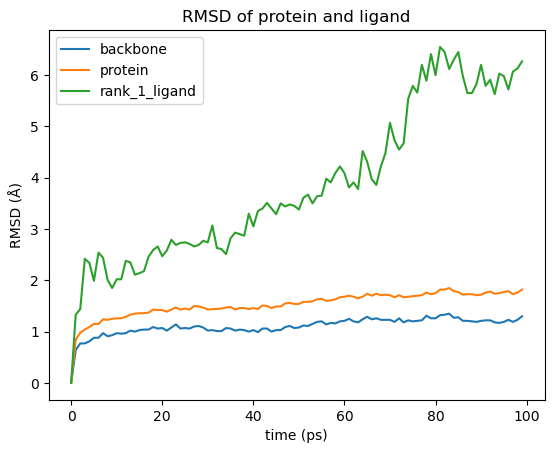

In [27]:
rmsd.plot(title="RMSD of protein and ligand")
plt.xlabel("time (ps)")
plt.ylabel("RMSD (Å)");
plt.savefig("rank1_rmsd_results")

In [28]:
rmsd.to_csv("rank_1_rmsd_results.csv")

## RMSF Analysis

In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import MDAnalysis.transformations as trans
from MDAnalysis.analysis.rms import RMSF

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
md_universe = mda.Universe(str("./topology_1.pdb"), str("./trajectory_1.xtc"))

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:276: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [4]:
protein = md_universe.select_atoms("protein")

In [5]:
# 1) need a step to center and make whole: this trajectory
#    contains the protein being split across periodic boundaries
#
# TODO

In [6]:
#not_protein = md_universe.select_atoms("not protein")

In [7]:
#transforms = [trans.unwrap(protein),
#              trans.center_in_box(protein, wrap=True),
#              trans.wrap(not_protein)]
#md_universe.trajectory.add_transformations(*transforms)

In [8]:
# 2) fit to the initial frame to get a better average structure
#    (the trajectory is changed in memory)

In [9]:
prealigner = align.AlignTraj(md_universe, md_universe, select="protein and name CA",
                             in_memory=True).run()

In [10]:
# 3) reference = average structure
reference_coordinates = md_universe.trajectory.timeseries(asel=protein).mean(axis=1)
# make a reference structure (need to reshape into a 1-frame "trajectory")
reference = mda.Merge(protein).load_new(
    reference_coordinates[:, None, :], order="afc")

- We created a new universe reference that contains a single frame with the averaged coordinates of the protein.
- Now we need to fit the whole trajectory to the reference by minimizing the RMSD. 
- We use MDAnalysis.analysis.align.AlignTraj:

In [11]:
aligner = align.AlignTraj(md_universe, reference, select="protein and name CA", in_memory=True).run()

- The trajectory is now fitted to the reference (the RMSD is stored as aligner.rmsd for further inspection). 
- Now we can calculate the RMSF:

In [12]:
calphas = protein.select_atoms("name CA")
rmsfer = RMSF(calphas, verbose=True).run()

  0%|          | 0/100 [00:00<?, ?it/s]

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:877: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


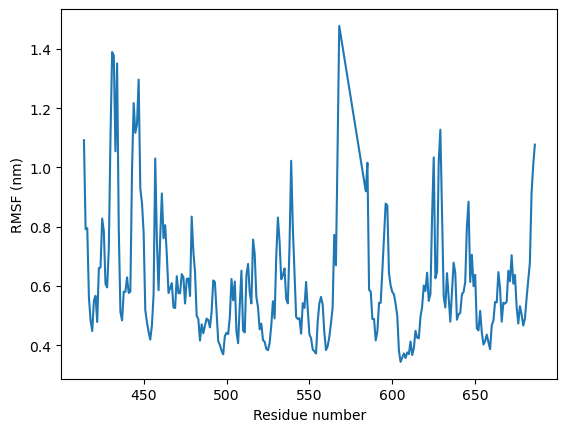

In [13]:
plt.plot(calphas.resnums, rmsfer.rmsf)
plt.xlabel("Residue number")
plt.ylabel("RMSF (nm)")
plt.savefig("rank1_rmsf_results.png")

In [14]:
calphas.resnums

array([414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504,
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
       518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530,
       531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543,
       544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
       557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 584,
       585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
       598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 60

In [15]:
len(calphas.resnums)

258

In [16]:
rmsfer.rmsf

array([1.0921218 , 0.79192003, 0.79540092, 0.56231022, 0.48463295,
       0.4483983 , 0.55103196, 0.56734444, 0.47901374, 0.66050914,
       0.66295527, 0.82782201, 0.78480778, 0.60741965, 0.59564873,
       0.72594191, 1.09916961, 1.38924537, 1.37727789, 1.05465437,
       1.35101935, 0.79521889, 0.5126986 , 0.48440207, 0.58090405,
       0.58094959, 0.62947707, 0.57702535, 0.58132659, 0.99103504,
       1.21725624, 1.11684818, 1.1447365 , 1.2964011 , 0.92801557,
       0.88109998, 0.78071712, 0.51947656, 0.47866141, 0.44579536,
       0.41956121, 0.4673644 , 0.57019666, 1.03051812, 0.75347175,
       0.58615264, 0.76329794, 0.91257744, 0.76148499, 0.80558204,
       0.7047297 , 0.57659471, 0.59355412, 0.61016354, 0.52793603,
       0.52612005, 0.63350994, 0.57622767, 0.57608438, 0.64049462,
       0.62962482, 0.54123723, 0.62388356, 0.62600899, 0.56658548,
       0.83436439, 0.716174  , 0.64917751, 0.50001604, 0.48872732,
       0.41657813, 0.47113913, 0.4409516 , 0.46691097, 0.49051

In [17]:
len(rmsfer.rmsf)

258

In [18]:
rank1_rmsf_df = pd.DataFrame({"residue": calphas.resnums, "rmsf": rmsfer.rmsf})
rank1_rmsf_df.head()
rank1_rmsf_df.to_csv("rank1_rmsf_results.csv")